In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import math  # This library is to use normal math functions like exp,sin etc.

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# These following imports are required because we have to upload image files from drive to colab
import zipfile # To unzip
import os      # To upload files
import cv2     # To read image files

## Extracting images from ZIP files and importing to colab

In [ ]:
# Set the path of the zip file in Google Drive
zip_path = "/content/drive/MyDrive/Prnn/Assignment1_resized_images.zip"

# Set the path to extract the zip file to in the Colab environment
extract_path = "/content"

# Extract the zip file to the specified path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
extract_path = "/content/Assignment1_resized_images"

In [ ]:
# Creating a list of list of images of particular class
lst_img_clss = []
for class_folder in sorted(os.listdir(extract_path)):
  class_folder_path = os.path.join(extract_path, class_folder)
  temp = []
  for filename in sorted(os.listdir(class_folder_path)):
    file_paths = os.path.join(class_folder_path, filename)
    img = cv2.imread(file_paths)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    temp.append(gray_img)
  lst_img_clss.append(temp)

In [ ]:
classes = len(lst_img_clss) # 10

## Creating dataset from images

In [ ]:
X=[]
Y = []
for i in range(classes):
  tmp = []
  for j in range(len(lst_img_clss[i])):
    x = np.ndarray.flatten(lst_img_clss[i][j])
    tmp.append(x)
  a = np.stack(tmp,axis = 0)
  X.append(a)
  Y.append(i)


In [ ]:
a = X[0]
b = np.zeros((X[0].shape[0],1))
dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  b = i*np.ones((X[i].shape[0],1))
  temp = np.column_stack((a,b))
  dataset = np.row_stack((dataset,temp))

In [ ]:
dataset.shape  # Overall dataset

(60000, 785)

## Creating functions for GMM

In [ ]:
def p4_split_dataset(dataset,train_ratio):
  classes = np.unique(dataset[:,-1])
  dataset_size = dataset.shape[0]
  count = int(train_ratio*(dataset_size))

  np.random.shuffle(dataset)
  train_dataset, test_dataset = dataset[:count,:], dataset[count:,:]

  return train_dataset,test_dataset

In [ ]:
def p4_GMM_training(train_dataset,epochs,number_of_Gaussian):
  min_class = int(np.min(train_dataset[:,-1]))
  classes = int(len(np.unique(train_dataset[:,-1])))
  dimension = train_dataset.shape[1]-1

  Category_wise_train_data = []

  for i in range(classes):
    Category_wise_train_data.append(train_dataset[train_dataset[:,-1]==(i+min_class)][:,:-1])



  Means = []
  Pi = []

  epochs = 10
  for digit_class in range(classes):
    Category_wise_epochs = 0
    Category_wise_Means = np.random.random_sample((dimension,number_of_Gaussian)) #np.random.uniform(0, 1,(dimension,number_of_Gaussian)) #np.zeros((dimension,number_of_Gaussian))
    Category_wise_Pi = np.ones(number_of_Gaussian)/number_of_Gaussian

    for Category_wise_epochs in range(epochs):

        Category_wise_Gamma = np.zeros((Category_wise_train_data[digit_class].shape[0],number_of_Gaussian))


        data_point_number = 0

        #Calculating Gamma for each datapoint and each class
        for data_point in Category_wise_train_data[digit_class]:
            Gamma_each_Gaussian = np.zeros(number_of_Gaussian)
            for k in range(number_of_Gaussian):

                temp1 = data_point-Category_wise_Means[:,k]

                temp3 = (-1/2)*(np.power(np.linalg.norm(temp1),2))

                temp4 = np.exp(temp3)

                temp5 = temp4*Category_wise_Pi[k]

                Gamma_each_Gaussian[k] = temp5

            Gamma_each_Gaussian = Gamma_each_Gaussian/np.sum(Gamma_each_Gaussian)

            Category_wise_Gamma[data_point_number,:] = Gamma_each_Gaussian

            data_point_number += 1



        # Updating mean

        for k in range(number_of_Gaussian):
            #updating mean in one line
            Category_wise_Means[:,k] = np.average(Category_wise_train_data[digit_class],axis = 0, weights=Category_wise_Gamma[:,k])


        # Updating Co-variance matrix

        Nk = np.sum(Category_wise_Gamma,axis = 0)


        # Updating Pi

        Category_wise_Pi = Nk/Category_wise_train_data[digit_class].shape[0]

    Means.append(Category_wise_Means)
    Pi.append(Category_wise_Pi)


  return Means,Pi


In [ ]:
def p4_GMM_testing(test_dataset,classes,Means,Pi,number_of_Gaussian):
  min_class = int(np.min(test_dataset[:,-1]))
  dimension = test_dataset.shape[1]-1

  confusion_matrix = np.zeros((classes,classes))


  correct_predicted_labels = 0
  for data_point in test_dataset:

    probabilities = np.zeros(classes)

    for Class in range(classes):

      Inner_summation = 0.0
      for k in range(number_of_Gaussian):
        temp1 = data_point[:-1]-Means[Class][:,k]
        temp3 = (-1/2)*(np.power(np.linalg.norm(temp1),2))
        temp4 = np.exp(temp3)
        temp5 = temp4*Pi[Class][k]
        Inner_summation += temp5
      probabilities[Class] = Inner_summation
    predicted_class = np.argmax(probabilities)
    confusion_matrix[predicted_class][int(data_point[-1])] += 1
    if(predicted_class==int(data_point[-1])):
      correct_predicted_labels += 1


  accuracy = correct_predicted_labels/test_dataset.shape[0]

  return accuracy,confusion_matrix

In [ ]:
def p4_get_likelihood(dataset,Means,Pi,number_of_Gaussian):
  min_class = int(np.min(dataset[:,-1]))
  dimension = dataset.shape[1]-1


  log_likelihood = 0.0
  data_point_number = 0

  for data_point in dataset:
      Inner_summation = 0.0
      for k in range(number_of_Gaussian):
          temp1 = data_point[:-1]-Means[int(data_point[-1])-min_class][:,k]

          temp3 = (-1/2)*(np.power(np.linalg.norm(temp1),2))
          temp4 = np.exp(temp3)

          temp5 = temp4*Pi[int(data_point[-1])-min_class][k]
          Inner_summation += temp5

      log_likelihood += np.log(Inner_summation)

      data_point_number += 1

  return log_likelihood

In [ ]:
def p4_normalize_Image_dataset(dataset):
  dataset = np.c_[ dataset[:,:-1]/255, dataset[:,-1]]
  return dataset

In [ ]:
p4dataset = dataset


In [ ]:
p4dataset = p4_normalize_Image_dataset(p4dataset)

In [ ]:
np.set_printoptions(suppress=True)

## Model 1 - 20:80

In [ ]:
# creating training and testing dataset
count = 1500 #per class
a=X[0]
a=a[0:count,:]/255       # Normalising else exponent becomes 0
b = np.zeros((a.shape[0],1))
train_dataset = np.column_stack((a,b))
a=X[0]
a=a[count:,:]/255
b = np.zeros((a.shape[0],1))
test_dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  a=a[0:count,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  train_dataset = np.row_stack((train_dataset,temp))
  a=X[i]
  a=a[count:,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  test_dataset = np.row_stack((test_dataset,temp))


In [ ]:
train_dataset.shape

(15000, 785)

In [ ]:
test_dataset.shape

(45000, 785)

In [ ]:
features = train_dataset.shape[1]-1 #784

In [ ]:
# Initialising features and labels from dataset
X_test = test_dataset[:,:features]
X_train = train_dataset[:,:features]
Y_train = train_dataset[:,features]
Y_test = test_dataset[:,features]

### (i) Naive Bayes

In [ ]:
classes = 10
features = train_dataset.shape[1]-1

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset
lst = []
for i in range(classes):
  x = temp[np.where(temp[:,features]==i)] # last column is my class indexes
  x = x[:,:features]
  lst.append(x)

In [ ]:
# 10 features' mean for each classes
mean=[]
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    k = math.exp(-k)
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_train[i]):
    count=count+1

In [ ]:
print('The training accuracy is:')
print(count*100/X_train.shape[0])

The training accuracy is:
83.74


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
for i in range(X_test.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    #k = math.exp(-k)
    g.append(k)
  k = g.index(min(g))
  if k==int(Y_test[i]):
    count=count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
84.36


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[3760  341    0   85   92    1    8  101   55   57]
 [  62 3823    0  285  118    7    1   37   16  151]
 [ 161   32 3601  123   19  460   10   77   11    6]
 [  40    3    2 3850  124   33   81  365    1    1]
 [   1    2    0   54 4255   67    0   97    8   16]
 [   1   28   25  274  318 3762    6   29   29   28]
 [   3    2    1   23   17   36 3744  662    2   10]
 [   3    2    2  191   60   10 1202 3028    2    0]
 [ 145   26    1   14   25   17    7   14 4188   63]
 [  66   34    0    6  167   12    8  117  139 3951]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8602150537634409, 0.8695553281018993, 0.8856369896704378, 0.8187134502923976, 0.8777720474471377, 0.8449185850645705, 0.7826904985888994, 0.6708762601085632, 0.9357613674449782, 0.8996925879540021]


### (ii) Logistic regression

In [ ]:
classes = 10
features = train_dataset.shape[1] #785 after augmented data

In [ ]:
#RUN only ONCE
tmp = np.ones((X_train.shape[0],1))  # Creating augmented data
X_train=np.column_stack((X_train,tmp))
X_train.shape

(15000, 785)

In [ ]:
tmp = np.ones((X_test.shape[0],1))  # Creating augmented data
X_test=np.column_stack((X_test,tmp))
X_test.shape

(45000, 785)

#### Training

In [ ]:
W=[]
for i in range(classes):
  W.append(np.ones((features,1)))

In [ ]:
def calc_loss(x,W,j):
  x=x.reshape((x.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for i in range(classes):
    e.append(math.exp(W[i].T@x))
  k = sum(e)
  for i in range(classes):
    g.append(e[i]/k)
  loss = -1*math.log(g[j])     # loss for 1 image
  for i in range(classes):
    if i!=j:
      grad.append(-g[i]*x.reshape(x.shape[0]))
    else:
      grad.append((1-g[i])*x.reshape(x.shape[0]))
  return loss,grad

In [ ]:
def train_epoch1():
  final_loss = 0
  final_grad = np.zeros((features,classes))
  for i in range(X_train.shape[0]):
    loss,grad = calc_loss(X_train[i,:],W,int(Y_train[i]))
    final_loss =final_loss + loss
    final_grad = final_grad + np.stack(grad,axis = 1)
  return final_loss,final_grad

In [ ]:
epochs = 50
alpha = 10
prev_loss = 0
for i in range(epochs):
  loss,grad = train_epoch1()
  for j in range(classes):
    gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
    if prev_loss<loss:
      alpha = (alpha/10)
    W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
    prev_loss = loss
  print('loss in',i,'epoch is',loss/X_train.shape[0])

loss in 0 epoch is 2.302585092994409
loss in 1 epoch is 1.116065690390648
loss in 2 epoch is 15.448510782036953
loss in 3 epoch is 13.785077708545925
loss in 4 epoch is 12.121777670357574
loss in 5 epoch is 10.458548464747944
loss in 6 epoch is 8.79536682651854
loss in 7 epoch is 7.132227013739376
loss in 8 epoch is 5.469542241388709
loss in 9 epoch is 3.8282372188040674
loss in 10 epoch is 2.5181019198708374
loss in 11 epoch is 1.330806733841259
loss in 12 epoch is 0.9624550921498767
loss in 13 epoch is 1.2827477812125414
loss in 14 epoch is 1.1723119540063145
loss in 15 epoch is 1.0759492890134754
loss in 16 epoch is 0.9957419545088523
loss in 17 epoch is 0.9316261355341784
loss in 18 epoch is 0.8814754956500138
loss in 19 epoch is 0.8489224059904316
loss in 20 epoch is 0.8354553755146794
loss in 21 epoch is 0.8311046492283262
loss in 22 epoch is 0.8292034797048633
loss in 23 epoch is 0.8259725393861008
loss in 24 epoch is 0.823961330183957
loss in 25 epoch is 0.8209350594237329
loss

In [ ]:
W[0].shape

(785, 1)

In [ ]:
print('Empirical risk on training data is:')
print(loss/X_train.shape[0])  # Doing 1/n

Empirical risk on training data is:
0.7735358190087274


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
loss = 0
for i in range(X_test.shape[0]):
  X = X_test[i,:]
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for j in range(classes):
    e.append(math.exp(W[j].T@X))
  k = sum(e)
  for j in range(classes):
    g.append(e[j]/k)
  k = g.index(max(g))
  if k==Y_test[i]:
    count = count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

  loss = loss - 1*math.log(g[v])

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
86.13333333333334


In [ ]:
print('Empirical risk on testing data is:')
print(loss/X_test.shape[0])

Empirical risk on testing data is:
0.7485922734396865


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[3925  286    1   60   70    0    9   32   88   29]
 [  98 3876    0  221  120   10    4    8   25  138]
 [ 184   18 3872   82   17  288    7   10   20    2]
 [  64    2    4 4018  124   34   97  151    5    1]
 [   1    1    0   56 4309   62    0   43   17   11]
 [   3   26   34  250  333 3758    8   13   53   22]
 [   4    1    3   22   29   31 3975  419    4   12]
 [   5    1    2  388   73   10 1227 2790    3    1]
 [  72   13    2    6   17    4   10    2 4338   36]
 [  94   18    0    7  188   12   11   86  185 3899]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8770949720670391, 0.8867536032944406, 0.9199334758850083, 0.8362122788761707, 0.8811860940695296, 0.8630152715581583, 0.8072705117790414, 0.6928234417680655, 0.9391643212816627, 0.9013986822332678]


### (iii) GMM

Accuracy for  1  mixtures is :  0.8557916666666666
F1 scores  1  mixtures is :  [0.8500746427809768, 0.8876706661150187, 0.927542654553512, 0.8338667442537097, 0.8762309326124734, 0.8933711524319782, 0.8043860556532534, 0.7025721784776903, 0.8857236770023008, 0.902239677316633]
Confusion matrix for  1  mixtures is :  [[3986.   82.  133.   38.   11.    1.    3.   24.  184.   83.]
 [ 339. 4291.   32.    4.    1.   21.    3.    3.  116.    8.]
 [   0.    0. 4186.    2.    0.   40.    4.    4.    2.    0.]
 [ 174.  217.  110. 4299.   54.  208.   50.  308.   66.   19.]
 [  85.   85.    6.  158. 4538.  196.   30.  204.   99.  204.]
 [   7.   16.  170.   48.   88. 4252.   36.   17.   85.   10.]
 [   8.    0.    4.   34.    5.   15. 3888.  893.   20.   12.]
 [  46.   11.  138.  222.   29.   27.  767. 3346.    7.  128.]
 [ 142.   36.    6.    0.    7.   19.    0.    1. 4042.  109.]
 [  46.  112.    3.    1.   20.   11.    7.    4.  144. 4250.]]
Accuracy for  2  mixtures is :  0.8788333333333334

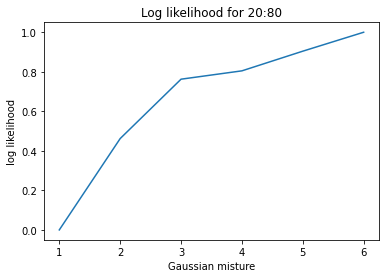

In [ ]:
train_dataset1,test_dataset1 = p4_split_dataset(p4dataset,0.2)
classes = 10
y1 = np.zeros(6)
x1 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x1:
  Means1,Pi1 = p4_GMM_training(train_dataset1,5,number_of_Gaussian)
  accuracy1,confusion_matrix1 = p4_GMM_testing(test_dataset1,10,Means1,Pi1,number_of_Gaussian)
  TP1=[]
  TN1=[]
  FP1=[]
  FN1=[]
  F11=[]
  for i in range(classes):
    TP1.append(confusion_matrix1[i][i])
    TN1.append(np.sum(confusion_matrix1)-np.sum(confusion_matrix1[i,:])-np.sum(confusion_matrix1[:,i])+confusion_matrix1[i][i])
    FP1.append(np.sum(confusion_matrix1[i,:])-confusion_matrix1[i][i])
    FN1.append(np.sum(confusion_matrix1[:,i])-confusion_matrix1[i][i])
    F11.append((2*TP1[i])/(2*TP1[i] + FP1[i] + FN1[i]))
  y1[number_of_Gaussian-1] = p4_get_likelihood(train_dataset1,Means1,Pi1,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy1)
  print("F1 scores ",number_of_Gaussian," mixtures is : ",F11)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix1)

y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))
plt.plot(x1,y1)
plt.title("Log likelihood for 20:80")
plt.xlabel("Gaussian misture")
plt.ylabel("log likelihood")
plt.show()

## Model 2 - 30:70

Again initialising dataset as X was used variable elsewhere

In [ ]:
X=[]
Y = []
for i in range(classes):
  tmp = []
  for j in range(len(lst_img_clss[i])):
    x = np.ndarray.flatten(lst_img_clss[i][j])
    tmp.append(x)
  a = np.stack(tmp,axis = 0)
  X.append(a)
  Y.append(i)


In [ ]:
a = X[0]
b = np.zeros((X[0].shape[0],1))
dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  b = i*np.ones((X[i].shape[0],1))
  temp = np.column_stack((a,b))
  dataset = np.row_stack((dataset,temp))

In [ ]:
dataset.shape  # Overall dataset

(60000, 785)

In [ ]:
# creating training and testing dataset
count = 1800 #per class
a=X[0]
a=a[0:count,:]/255       # Normalising else exponent becomes 0
b = np.zeros((a.shape[0],1))
train_dataset = np.column_stack((a,b))
a=X[0]
a=a[count:,:]/255
b = np.zeros((a.shape[0],1))
test_dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  a=a[0:count,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  train_dataset = np.row_stack((train_dataset,temp))
  a=X[i]
  a=a[count:,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  test_dataset = np.row_stack((test_dataset,temp))


In [ ]:
train_dataset.shape

(18000, 785)

In [ ]:
test_dataset.shape

(42000, 785)

In [ ]:
features = train_dataset.shape[1]-1 #784

In [ ]:
# Initialising features and labels from dataset
X_test = test_dataset[:,:features]
X_train = train_dataset[:,:features]
Y_train = train_dataset[:,features]
Y_test = test_dataset[:,features]

### (i) Naive Bayes

In [ ]:
classes = 10
features = train_dataset.shape[1]-1

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset
lst = []
for i in range(classes):
  x = temp[np.where(temp[:,features]==i)] # last column is my class indexes
  x = x[:,:features]
  lst.append(x)

In [ ]:
# 10 features' mean for each classes
mean=[]
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    k = math.exp(-k)
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_train[i]):
    count=count+1

In [ ]:
print('The training accuracy is:')
print(count*100/X_train.shape[0])

The training accuracy is:
84.25


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
for i in range(X_test.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    #k = math.exp(-k)
    g.append(k)
  k = g.index(min(g))
  if k==int(Y_test[i]):
    count=count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
84.37857142857143


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[3449  353    0   66   96    1    8  110   57   60]
 [  55 3626    0  206  112    7    2   37   18  137]
 [ 115   36 3352   89   29  481    6   72   11    9]
 [  38    4    2 3512  138   48   76  379    1    2]
 [   0    1    0   23 3987   71    0  102    4   12]
 [   1   27   32  165  302 3583   14   26   27   23]
 [   3    0    1   15   15   34 3487  635    1    9]
 [   3    2    2  149   47   10 1165 2820    2    0]
 [  95   25    1   15   27   20    4    9 3939   65]
 [  53   26    0    4  178    9    9  122  115 3684]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8609585621567648, 0.8737349397590362, 0.8832674571805007, 0.8318332543818096, 0.8732887964078414, 0.8466446124763705, 0.7773938245457586, 0.6625939849624061, 0.9406567164179105, 0.8984270210949884]


### (ii) Logistic regression

In [ ]:
classes = 10
features = train_dataset.shape[1] #785 after augmented data

In [ ]:
tmp = np.ones((X_train.shape[0],1))  # Creating augmented data
X_train=np.column_stack((X_train,tmp))
X_train.shape

(18000, 785)

In [ ]:
tmp = np.ones((X_test.shape[0],1))  # Creating augmented data
X_test=np.column_stack((X_test,tmp))
X_test.shape

(42000, 785)

#### Training

In [ ]:
W=[]
for i in range(classes):
  W.append(np.ones((features,1)))

In [ ]:
def calc_loss(X,W,j):
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for i in range(classes):
    e.append(math.exp(W[i].T@X))
  k = sum(e)
  for i in range(classes):
    g.append(e[i]/k)
  loss = -1*math.log(g[j])     # loss for 1 image
  for i in range(classes):
    if i!=j:
      grad.append(-g[i]*X.reshape(X.shape[0]))
    else:
      grad.append((1-g[i])*X.reshape(X.shape[0]))
  return loss,grad

In [ ]:
def train_epoch1():
  final_loss = 0
  final_grad = np.zeros((features,classes))
  for i in range(X_train.shape[0]):
    loss,grad = calc_loss(X_train[i,:],W,int(Y_train[i]))
    final_loss =final_loss + loss
    final_grad = final_grad + np.stack(grad,axis = 1)
  return final_loss,final_grad

In [ ]:
epochs = 50
alpha = 10
prev_loss = 0
for i in range(epochs):
  loss,grad = train_epoch1()
  for j in range(classes):
    gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
    if prev_loss<loss:
      alpha = (alpha/10)
    W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
    prev_loss = loss
  print('loss in',i,'epoch is',loss/X_train.shape[0])

loss in 0 epoch is 2.302585092993949
loss in 1 epoch is 1.109937657051293
loss in 2 epoch is 15.64977940250885
loss in 3 epoch is 14.867888941254881
loss in 4 epoch is 13.995138011698831
loss in 5 epoch is 13.100708589633108
loss in 6 epoch is 12.307237875519634
loss in 7 epoch is 11.40377291053196
loss in 8 epoch is 10.619744783719701
loss in 9 epoch is 9.7100985645489
loss in 10 epoch is 8.932746719906728
loss in 11 epoch is 8.018582031067721
loss in 12 epoch is 7.246156543602161
loss in 13 epoch is 6.328672832902279
loss in 14 epoch is 5.56002037994501
loss in 15 epoch is 4.642430033140454
loss in 16 epoch is 3.88123865285457
loss in 17 epoch is 3.034157068900151
loss in 18 epoch is 2.370007416795513
loss in 19 epoch is 1.7839059625244453
loss in 20 epoch is 1.2491039263548163
loss in 21 epoch is 1.1972351009497333
loss in 22 epoch is 1.2154048923244392
loss in 23 epoch is 1.1047158906988248
loss in 24 epoch is 1.0118033866178344
loss in 25 epoch is 0.9372004136921211
loss in 26 epo

In [ ]:
print('Empirical risk on training data is:')
print(loss/X_train.shape[0])

Empirical risk on training data is:
0.7282317224520557


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
loss=0
for i in range(X_test.shape[0]):
  X = X_test[i,:]
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for j in range(classes):
    e.append(math.exp(W[j].T@X))
  k = sum(e)
  for j in range(classes):
    g.append(e[j]/k)
  k = g.index(max(g))
  if k==Y_test[i]:
    count = count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

  loss = loss - 1*math.log(g[v])

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
87.02857142857142


In [ ]:
print('Empirical risk on testing data is:')
print(loss/X_test.shape[0])

Empirical risk on testing data is:
0.7178242339485161


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[3613  298    4   49   42    0    5   42   76   71]
 [  91 3661    0  169   57   13    2    9   22  176]
 [ 112   22 3762   54    8  204    3   11   18    6]
 [  63    4   19 3721  100   49   58  179    4    3]
 [   1    1    0   36 3944   79    0   86   17   36]
 [   3   30   46  159  218 3623    4   17   47   53]
 [   4    0    9   18   15   39 3570  526    4   15]
 [   5    1   15  275   41   17 1009 2832    3    2]
 [  62   17    2    6   12    7    2    2 4036   54]
 [  60    3    0    4  103    6   10   92  132 3790]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.879717555393231, 0.8889158674274614, 0.9338463447933474, 0.8562881141410654, 0.9025171624713959, 0.879689207235644, 0.8055962992214826, 0.7083541770885443, 0.9431008295361608, 0.901736854627647]


### (iii) GMM

Accuracy for  1  mixtures is :  0.8521904761904762
F1 scores  1  mixtures is :  [0.8436345727653287, 0.8895472860867504, 0.9238683127572016, 0.8289488289488289, 0.8753635678121297, 0.8943584744730109, 0.7947882736156352, 0.685672867842474, 0.8913931888544891, 0.9009250243427459]
Confusion matrix for  1  mixtures is :  [[3426.   65.  121.   31.    4.    1.    5.   20.  152.   79.]
 [ 315. 3753.   32.    4.    2.   20.    1.    1.   79.    9.]
 [   1.    0. 3592.    1.    0.   30.    2.    5.    1.    0.]
 [ 161.  200.  101. 3734.   40.  202.   48.  268.   62.   19.]
 [  89.   78.    9.  143. 4063.  178.   32.  180.   96.  194.]
 [   4.   12.  145.   36.   72. 3670.   29.   11.   55.   12.]
 [   9.    1.    2.   23.    1.   16. 3416.  854.   19.   12.]
 [  50.   14.  134.  202.   22.   20.  706. 2838.    8.  102.]
 [ 123.   16.    5.    0.    6.   17.    0.    2. 3599.  100.]
 [  40.   83.    3.    0.   11.    7.    4.    3.  136. 3701.]]
Accuracy for  2  mixtures is :  0.881547619047619

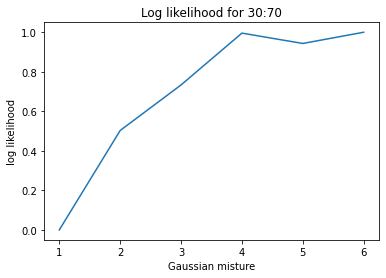

In [ ]:
train_dataset2,test_dataset2 = p4_split_dataset(p4dataset,0.3)
classes = 10
y2 = np.zeros(6)
x2 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x2:
  Means2,Pi2 = p4_GMM_training(train_dataset2,5,number_of_Gaussian)
  accuracy2,confusion_matrix2 = p4_GMM_testing(test_dataset2,10,Means2,Pi2,number_of_Gaussian)
  TP2=[]
  TN2=[]
  FP2=[]
  FN2=[]
  F12=[]
  for i in range(classes):
    TP2.append(confusion_matrix2[i][i])
    TN2.append(np.sum(confusion_matrix2)-np.sum(confusion_matrix2[i,:])-np.sum(confusion_matrix2[:,i])+confusion_matrix2[i][i])
    FP2.append(np.sum(confusion_matrix2[i,:])-confusion_matrix2[i][i])
    FN2.append(np.sum(confusion_matrix2[:,i])-confusion_matrix2[i][i])
    F12.append((2*TP2[i])/(2*TP2[i] + FP2[i] + FN2[i]))
  y2[number_of_Gaussian-1] = p4_get_likelihood(train_dataset2,Means2,Pi2,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy2)
  print("F1 scores ",number_of_Gaussian," mixtures is : ",F12)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix2)

y2 = (y2-np.min(y2))/(np.max(y2)-np.min(y2))
plt.plot(x2,y2)
plt.title("Log likelihood for 30:70")
plt.ylabel("log likelihood")
plt.xlabel("Gaussian misture")
plt.show()

## Model 3 - 50:50

Again initialising dataset as X was used variable elsewhere

In [ ]:
X=[]
Y = []
for i in range(classes):
  tmp = []
  for j in range(len(lst_img_clss[i])):
    x = np.ndarray.flatten(lst_img_clss[i][j])
    tmp.append(x)
  a = np.stack(tmp,axis = 0)
  X.append(a)
  Y.append(i)


In [ ]:
a = X[0]
b = np.zeros((X[0].shape[0],1))
dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  b = i*np.ones((X[i].shape[0],1))
  temp = np.column_stack((a,b))
  dataset = np.row_stack((dataset,temp))

In [ ]:
dataset.shape  # Overall dataset

(60000, 785)

In [ ]:
# creating training and testing dataset
count = 3000 #per class
a=X[0]
a=a[0:count,:]/255       # Normalising else exponent becomes 0
b = np.zeros((a.shape[0],1))
train_dataset = np.column_stack((a,b))
a=X[0]
a=a[count:,:]/255
b = np.zeros((a.shape[0],1))
test_dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  a=a[0:count,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  train_dataset = np.row_stack((train_dataset,temp))
  a=X[i]
  a=a[count:,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  test_dataset = np.row_stack((test_dataset,temp))


In [ ]:
train_dataset.shape

(30000, 785)

In [ ]:
test_dataset.shape

(30000, 785)

In [ ]:
features = train_dataset.shape[1]-1 #784

In [ ]:
# Initialising features and labels from dataset
X_test = test_dataset[:,:features]
X_train = train_dataset[:,:features]
Y_train = train_dataset[:,features]
Y_test = test_dataset[:,features]

### (i) Naive Bayes

In [ ]:
classes = 10
features = train_dataset.shape[1]-1

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset
lst = []
for i in range(classes):
  x = temp[np.where(temp[:,features]==i)] # last column is my class indexes
  x = x[:,:features]
  lst.append(x)

In [ ]:
# 10 features' mean for each classes
mean=[]
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    k = math.exp(-k)
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_train[i]):
    count=count+1

In [ ]:
print('The training accuracy is:')
print(count*100/X_train.shape[0])

The training accuracy is:
84.82333333333334


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
for i in range(X_test.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    #k = math.exp(-k)
    g.append(k)
  k = g.index(min(g))
  if k==int(Y_test[i]):
    count=count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
86.12


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[2633  188    0   27   37    1   10   46   46   12]
 [  54 2712    0   89   57    7    1    5   32   43]
 [  96   32 2503   97   12  177    6   68    6    3]
 [  34    2    0 2631  106   22   39  165    0    1]
 [   1    1    0    9 2863   83    0   32    4    7]
 [   1   29   29  105  198 2580    7   16   18   17]
 [   1    1    0   16   15   15 2509  437    0    6]
 [   2    1    2  122   31   11  909 1920    2    0]
 [  62    5    1    1    7   10    2    2 2854   56]
 [  51   13    0    3   93    4    6   81  118 2631]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8872788542544229, 0.9064171122994652, 0.9044263775971093, 0.8626229508196721, 0.8920392584514721, 0.8730964467005076, 0.7733086762212976, 0.6652806652806653, 0.9388157894736842, 0.91101108033241]


### (ii) Logistic regression

In [ ]:
classes = 10
features = train_dataset.shape[1] #785 after augmented data

In [ ]:
tmp = np.ones((X_train.shape[0],1))  # Creating augmented data
X_train=np.column_stack((X_train,tmp))
X_train.shape

(30000, 785)

In [ ]:
tmp = np.ones((X_test.shape[0],1))  # Creating augmented data
X_test=np.column_stack((X_test,tmp))
X_test.shape

(30000, 785)

#### Training

In [ ]:
W=[]
for i in range(classes):
  W.append(np.ones((features,1)))

In [ ]:
def calc_loss(X,W,j):
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for i in range(classes):
    e.append(math.exp(W[i].T@X))
  k = sum(e)
  for i in range(classes):
    g.append(e[i]/k)
  loss = -1*math.log(g[j])     # loss for 1 image
  for i in range(classes):
    if i!=j:
      grad.append(-g[i]*X.reshape(X.shape[0]))
    else:
      grad.append((1-g[i])*X.reshape(X.shape[0]))
  return loss,grad

In [ ]:
def train_epoch1():
  final_loss = 0
  final_grad = np.zeros((features,classes))
  for i in range(X_train.shape[0]):
    loss,grad = calc_loss(X_train[i,:],W,int(Y_train[i]))
    final_loss =final_loss + loss
    final_grad = final_grad + np.stack(grad,axis = 1)
  return final_loss,final_grad

In [ ]:
epochs = 50
alpha = 10
prev_loss = 0
for i in range(epochs):
  loss,grad = train_epoch1()
  for j in range(classes):
    gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
    if prev_loss<loss:
      alpha = (alpha/10)
    W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
    prev_loss = loss
  print('loss in',i,'epoch is',loss/X_train.shape[0])

loss in 0 epoch is 2.3025850929934024
loss in 1 epoch is 1.1015164807183533
loss in 2 epoch is 15.996749007512783
loss in 3 epoch is 14.35179918806085
loss in 4 epoch is 12.689189031466176
loss in 5 epoch is 11.026585417436387
loss in 6 epoch is 9.36398815061454
loss in 7 epoch is 7.701397068861428
loss in 8 epoch is 6.0388135044398785
loss in 9 epoch is 4.3763354097555185
loss in 10 epoch is 2.7200301749632256
loss in 11 epoch is 1.2546646708158582
loss in 12 epoch is 1.1722500880166393
loss in 13 epoch is 1.093281597799932
loss in 14 epoch is 1.1808245654379308
loss in 15 epoch is 1.0583677820552513
loss in 16 epoch is 0.9662088709445491
loss in 17 epoch is 0.9003420226318095
loss in 18 epoch is 0.8582080847454168
loss in 19 epoch is 0.8345208021277007
loss in 20 epoch is 0.8258655895933181
loss in 21 epoch is 0.8215476513913776
loss in 22 epoch is 0.8190065983794665
loss in 23 epoch is 0.8178066409533886
loss in 24 epoch is 0.8149161090283084
loss in 25 epoch is 0.8134515281225305
l

In [ ]:
print('Empirical risk on training data is:')
print(loss/X_train.shape[0])

Empirical risk on training data is:
0.7682224303085692


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
loss = 0
for i in range(X_test.shape[0]):
  X = X_test[i,:]
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for j in range(classes):
    e.append(math.exp(W[j].T@X))
  k = sum(e)
  for j in range(classes):
    g.append(e[j]/k)
  k = g.index(max(g))
  if k==Y_test[i]:
    count = count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

  loss = loss - 1*math.log(g[v])

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
87.68333333333334


In [ ]:
print('Empirical risk on testing data is:')
print(loss/X_test.shape[0])

Empirical risk on testing data is:
0.7132966042489008


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[2575  243    2   12   33    1    7   46   74    7]
 [  19 2830    0   32   56    9    1    4   21   28]
 [  77   30 2682   43    7  114    3   34    9    1]
 [  43    8    1 2547  130   41   29  199    0    2]
 [   1    1    0    6 2853   96    0   27   10    6]
 [   0   37   30   40  166 2684    1   12   23    7]
 [   1    4    1    7   20   27 2460  475    0    5]
 [   2    1    8   96   33   24  677 2156    3    0]
 [  23    4    1    0    7    8    0    2 2928   27]
 [  41   18    0    1   95   10    6   77  162 2590]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8906952611553096, 0.9164507772020726, 0.9369432314410481, 0.8807053941908713, 0.8915625, 0.8925839707349518, 0.795601552393273, 0.7148541114058355, 0.9399678972712681, 0.9130971267407015]


### (iii) GMM

Accuracy for  1  mixtures is :  0.8584666666666667
F1 scores  1  mixtures is :  [0.8493528904227783, 0.8931156370981316, 0.9281255573390405, 0.8276721720162045, 0.8889567740950054, 0.8945803040317251, 0.8041136141038198, 0.69926733685466, 0.8971583220568335, 0.9063317634746206]
Confusion matrix for  1  mixtures is :  [[2461.   35.   86.   24.    4.    1.    3.   17.  115.   51.]
 [ 218. 2653.   26.    2.    1.   16.    2.    1.   58.    8.]
 [   1.    0. 2602.    1.    0.   28.    3.    6.    1.    0.]
 [ 116.  131.   63. 2656.   32.  143.   38.  200.   48.   11.]
 [  59.   41.    4.   88. 2910.  124.   20.  107.   53.  114.]
 [   3.   10.  105.   32.   45. 2707.   19.   10.   50.    9.]
 [   4.    0.    4.   25.    0.   12. 2463.  588.   16.    5.]
 [  27.    5.   72.  150.   18.   16.  460. 2052.    6.   79.]
 [  80.   20.    0.    0.    5.   11.    0.    0. 2652.   71.]
 [  29.   61.    3.    2.   12.    4.    1.    3.   74. 2598.]]
Accuracy for  2  mixtures is :  0.8861666666666667

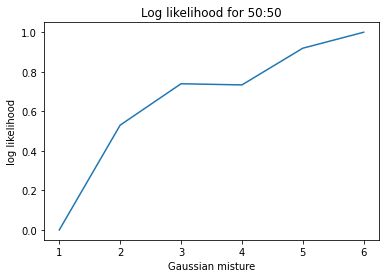

In [ ]:
train_dataset3,test_dataset3 = p4_split_dataset(p4dataset,0.5)
classes = 10
y3 = np.zeros(6)
x3 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x3:
  Means3,Pi3 = p4_GMM_training(train_dataset3,5,number_of_Gaussian)
  accuracy3,confusion_matrix3 = p4_GMM_testing(test_dataset3,10,Means3,Pi3,number_of_Gaussian)
  TP3=[]
  TN3=[]
  FP3=[]
  FN3=[]
  F13=[]
  for i in range(classes):
    TP3.append(confusion_matrix3[i][i])
    TN3.append(np.sum(confusion_matrix3)-np.sum(confusion_matrix3[i,:])-np.sum(confusion_matrix3[:,i])+confusion_matrix3[i][i])
    FP3.append(np.sum(confusion_matrix3[i,:])-confusion_matrix3[i][i])
    FN3.append(np.sum(confusion_matrix3[:,i])-confusion_matrix3[i][i])
    F13.append((2*TP3[i])/(2*TP3[i] + FP3[i] + FN3[i]))
  y3[number_of_Gaussian-1] = p4_get_likelihood(train_dataset3,Means3,Pi3,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy3)
  print("F1 scores ",number_of_Gaussian," mixtures is : ",F13)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix3)

y3 = (y3-np.min(y3))/(np.max(y3)-np.min(y3))
plt.plot(x3,y3)
plt.title("Log likelihood for 50:50")
plt.ylabel("log likelihood")
plt.xlabel("Gaussian misture")
plt.show()

## Model 4 - 70:30

 Again initialising dataset as X was used variable elsewhere

In [ ]:
X=[]
Y = []
for i in range(classes):
  tmp = []
  for j in range(len(lst_img_clss[i])):
    x = np.ndarray.flatten(lst_img_clss[i][j])
    tmp.append(x)
  a = np.stack(tmp,axis = 0)
  X.append(a)
  Y.append(i)


In [ ]:
a = X[0]
b = np.zeros((X[0].shape[0],1))
dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  b = i*np.ones((X[i].shape[0],1))
  temp = np.column_stack((a,b))
  dataset = np.row_stack((dataset,temp))

In [ ]:
dataset.shape  # Overall dataset

(60000, 785)

In [ ]:
# creating training and testing dataset
count = 4200 #per class
a=X[0]
a=a[0:count,:]/255       # Normalising else exponent becomes 0
b = np.zeros((a.shape[0],1))
train_dataset = np.column_stack((a,b))
a=X[0]
a=a[count:,:]/255
b = np.zeros((a.shape[0],1))
test_dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  a=a[0:count,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  train_dataset = np.row_stack((train_dataset,temp))
  a=X[i]
  a=a[count:,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  test_dataset = np.row_stack((test_dataset,temp))


In [ ]:
train_dataset.shape

(42000, 785)

In [ ]:
test_dataset.shape

(18000, 785)

In [ ]:
features = train_dataset.shape[1]-1 #784

In [ ]:
# Initialising features and labels from dataset
X_test = test_dataset[:,:features]
X_train = train_dataset[:,:features]
Y_train = train_dataset[:,features]
Y_test = test_dataset[:,features]

### (i) Naive Bayes

In [ ]:
classes = 10
features = train_dataset.shape[1]-1

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset
lst = []
for i in range(classes):
  x = temp[np.where(temp[:,features]==i)] # last column is my class indexes
  x = x[:,:features]
  lst.append(x)

In [ ]:
# 10 features' mean for each classes
mean=[]
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    k = math.exp(-k)
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_train[i]):
    count=count+1

In [ ]:
print('The training accuracy is:')
print(count*100/X_train.shape[0])

The training accuracy is:
85.09285714285714


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
for i in range(X_test.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    #k = math.exp(-k)
    g.append(k)
  k = g.index(min(g))
  if k==int(Y_test[i]):
    count=count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
85.89444444444445


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[1595  121    0   16   23    0    2   12   22    9]
 [  30 1582    0   93   42    4    0    4   30   15]
 [  90   30 1383   95    6  120    6   66    3    1]
 [  21    2    0 1501  100    7   18  149    0    2]
 [   1    0    0    9 1740   32    0   16    0    2]
 [   1   14   26   63  116 1553    5    9    8    5]
 [   0    1    0   16   10   11 1575  183    0    4]
 [   2    1    2   68   35    4  383 1303    2    0]
 [  62    2    0    1    8   11    1    0 1647   68]
 [  20    5    0    0   67    4    6   42   74 1582]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8807288790723358, 0.8892636312535133, 0.8614138897539707, 0.8197706171490988, 0.8816822903470991, 0.8759165256627186, 0.8298208640674394, 0.7271205357142857, 0.9185722253206916, 0.9071100917431193]


### (ii) Logistic regression

In [ ]:
classes = 10
features = train_dataset.shape[1] #785 after augmented data

In [ ]:
tmp = np.ones((X_train.shape[0],1))  # Creating augmented data
X_train=np.column_stack((X_train,tmp))
X_train.shape

(42000, 785)

In [ ]:
tmp = np.ones((X_test.shape[0],1))  # Creating augmented data
X_test=np.column_stack((X_test,tmp))
X_test.shape

(18000, 785)

#### Training

In [ ]:
W=[]
for i in range(classes):
  W.append(np.ones((features,1)))

In [ ]:
def calc_loss(X,W,j):
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for i in range(classes):
    e.append(math.exp(W[i].T@X))
  k = sum(e)
  for i in range(classes):
    g.append(e[i]/k)
  loss = -1*math.log(g[j])     # loss for 1 image
  for i in range(classes):
    if i!=j:
      grad.append(-g[i]*X.reshape(X.shape[0]))
    else:
      grad.append((1-g[i])*X.reshape(X.shape[0]))
  return loss,grad

In [ ]:
def train_epoch1():
  final_loss = 0
  final_grad = np.zeros((features,classes))
  for i in range(X_train.shape[0]):
    loss,grad = calc_loss(X_train[i,:],W,int(Y_train[i]))
    final_loss =final_loss + loss
    final_grad = final_grad + np.stack(grad,axis = 1)
  return final_loss,final_grad

In [ ]:
epochs = 50
alpha = 10
prev_loss = 0
for i in range(epochs):
  loss,grad = train_epoch1()
  for j in range(classes):
    gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
    if prev_loss<loss:
      alpha = (alpha/10)
    W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
    prev_loss = loss
  print('loss in',i,'epoch is',loss/X_train.shape[0])

loss in 0 epoch is 2.3025850929949803
loss in 1 epoch is 1.071865758449463
loss in 2 epoch is 16.049248897047185
loss in 3 epoch is 14.386238639874653
loss in 4 epoch is 12.723348115217082
loss in 5 epoch is 11.060523865763443
loss in 6 epoch is 9.397743372229446
loss in 7 epoch is 7.734995039152109
loss in 8 epoch is 6.072273212070602
loss in 9 epoch is 4.409661089131037
loss in 10 epoch is 2.752553776122961
loss in 11 epoch is 1.2636248907181071
loss in 12 epoch is 1.0794215343483649
loss in 13 epoch is 1.2396430229940538
loss in 14 epoch is 1.1314355339393503
loss in 15 epoch is 1.037452166929742
loss in 16 epoch is 0.9598955148382359
loss in 17 epoch is 0.9008290163810643
loss in 18 epoch is 0.8578639628916568
loss in 19 epoch is 0.8293321776342419
loss in 20 epoch is 0.8161993661029197
loss in 21 epoch is 0.8111585573703298
loss in 22 epoch is 0.8095078461070596
loss in 23 epoch is 0.8069885248653499
loss in 24 epoch is 0.8051484163685908
loss in 25 epoch is 0.8028035840250733
los

In [ ]:
print('Empirical risk on training data is:')
print(loss/X_train.shape[0])

Empirical risk on training data is:
0.755659734141405


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
loss = 0
for i in range(X_test.shape[0]):
  X = X_test[i,:]
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for j in range(classes):
    e.append(math.exp(W[j].T@X))
  k = sum(e)
  for j in range(classes):
    g.append(e[j]/k)
  k = g.index(max(g))
  if k==Y_test[i]:
    count = count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

  loss = loss - 1*math.log(g[v])

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
87.85555555555555


In [ ]:
print('Empirical risk on testing data is:')
print(loss/X_test.shape[0])

Empirical risk on testing data is:
0.7132953150682471


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[1571  149    0   15   22    0    3    2   33    5]
 [  13 1654    0   61   34    4    1    1   21   11]
 [  80   27 1543   66    4   48   10   16    5    1]
 [  21    4    0 1571  103    6   18   75    0    2]
 [   1    0    0    9 1754   24    1    6    3    2]
 [   0   25   37   60  124 1524    8    4   14    4]
 [   0    1    1   16   15    8 1640  114    0    5]
 [   2    1    5  124   34    4  380 1248    2    0]
 [  20    1    0    0    7    4    2    0 1734   32]
 [  16    6    0    0   72    1    5   31   94 1575]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8916004540295119, 0.9018538713195202, 0.9113998818665091, 0.8441698011821601, 0.8838498362307886, 0.8904469763365469, 0.8479834539813857, 0.7570518653321201, 0.9357798165137615, 0.9164969450101833]


### (iii) GMM

Accuracy for  1  mixtures is :  0.8497222222222223
F1 scores  1  mixtures is :  [0.8358294930875576, 0.8908538270240398, 0.9276470588235294, 0.819369715603382, 0.8727552591072345, 0.8919683257918553, 0.7972862957937584, 0.6898839137645107, 0.8829663962920047, 0.8996195493122622]
Confusion matrix for  1  mixtures is :  [[1451.   42.   58.   19.    3.    0.    3.   10.   76.   27.]
 [ 117. 1612.   12.    2.    0.    9.    1.    1.   33.    3.]
 [   0.    0. 1577.    0.    0.   18.    1.    1.    0.    0.]
 [  72.   98.   34. 1599.   18.   83.   19.  112.   30.    7.]
 [  41.   23.    3.   72. 1701.   77.   10.   74.   45.   81.]
 [   0.    4.   61.   25.   31. 1577.   15.    3.   27.    9.]
 [   3.    0.    2.   15.    1.    2. 1469.  382.    6.    4.]
 [  19.    6.   55.   99.   11.    9.  281. 1248.    5.   51.]
 [  59.   13.    1.    0.    2.    7.    0.    1. 1524.   48.]
 [  21.   31.    0.    0.    4.    2.    2.    2.   51. 1537.]]
Accuracy for  2  mixtures is :  0.864555555555555

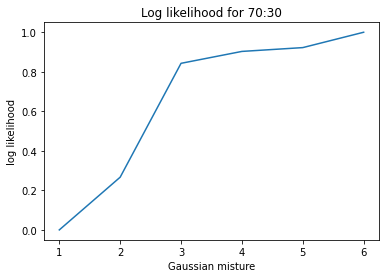

In [ ]:
train_dataset4,test_dataset4 = p4_split_dataset(p4dataset,0.7)
classes = 10
y4 = np.zeros(6)
x4 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x4:
  Means4,Pi4 = p4_GMM_training(train_dataset4,5,number_of_Gaussian)
  accuracy4,confusion_matrix4 = p4_GMM_testing(test_dataset4,10,Means4,Pi4,number_of_Gaussian)
  TP4=[]
  TN4=[]
  FP4=[]
  FN4=[]
  F14=[]
  for i in range(classes):
    TP4.append(confusion_matrix4[i][i])
    TN4.append(np.sum(confusion_matrix4)-np.sum(confusion_matrix4[i,:])-np.sum(confusion_matrix4[:,i])+confusion_matrix4[i][i])
    FP4.append(np.sum(confusion_matrix4[i,:])-confusion_matrix4[i][i])
    FN4.append(np.sum(confusion_matrix4[:,i])-confusion_matrix4[i][i])
    F14.append((2*TP4[i])/(2*TP4[i] + FP4[i] + FN4[i]))
  y4[number_of_Gaussian-1] = p4_get_likelihood(train_dataset4,Means4,Pi4,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy4)
  print("F1 scores ",number_of_Gaussian," mixtures is : ",F14)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix4)

y4 = (y4-np.min(y4))/(np.max(y4)-np.min(y4))
plt.plot(x4,y4)
plt.title("Log likelihood for 70:30")
plt.ylabel("log likelihood")
plt.xlabel("Gaussian misture")
plt.show()

## Model 5 - 90:10

 Again initialising dataset as X was used variable elsewhere

In [ ]:
X=[]
Y = []
for i in range(classes):
  tmp = []
  for j in range(len(lst_img_clss[i])):
    x = np.ndarray.flatten(lst_img_clss[i][j])
    tmp.append(x)
  a = np.stack(tmp,axis = 0)
  X.append(a)
  Y.append(i)


In [ ]:
a = X[0]
b = np.zeros((X[0].shape[0],1))
dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  b = i*np.ones((X[i].shape[0],1))
  temp = np.column_stack((a,b))
  dataset = np.row_stack((dataset,temp))

In [ ]:
dataset.shape  # Overall dataset

(60000, 785)

In [ ]:
# creating training and testing dataset
count = 5400 #per class
a=X[0]
a=a[0:count,:]/255       # Normalising else exponent becomes 0
b = np.zeros((a.shape[0],1))
train_dataset = np.column_stack((a,b))
a=X[0]
a=a[count:,:]/255
b = np.zeros((a.shape[0],1))
test_dataset = np.column_stack((a,b))
for i in range(1,classes):
  a=X[i]
  a=a[0:count,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  train_dataset = np.row_stack((train_dataset,temp))
  a=X[i]
  a=a[count:,:]/255
  b = i*np.ones((a.shape[0],1))
  temp = np.column_stack((a,b))
  test_dataset = np.row_stack((test_dataset,temp))


In [ ]:
train_dataset.shape

(54000, 785)

In [ ]:
test_dataset.shape

(6000, 785)

In [ ]:
features = train_dataset.shape[1]-1 #784

In [ ]:
# Initialising features and labels from dataset
X_test = test_dataset[:,:features]
X_train = train_dataset[:,:features]
Y_train = train_dataset[:,features]
Y_test = test_dataset[:,features]

### (i) Naive Bayes

In [ ]:
classes = 10
features = train_dataset.shape[1]-1

In [ ]:
# Creating list of numpy arrays containing training datas of each class with class as index of list
temp = train_dataset
lst = []
for i in range(classes):
  x = temp[np.where(temp[:,features]==i)] # last column is my class indexes
  x = x[:,:features]
  lst.append(x)

In [ ]:
# 10 features' mean for each classes
mean=[]
for i in range(classes):
  a=lst[i]
  a = a.mean(axis=0)
  mean.append(a)

#### Training

In [ ]:
count = 0
for i in range(X_train.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_train[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    k = math.exp(-k)
    g.append(k)
  k = g.index(max(g))
  if k==int(Y_train[i]):
    count=count+1

In [ ]:
print('The training accuracy is:')
print(count*100/X_train.shape[0])

The training accuracy is:
85.88518518518518


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
for i in range(X_test.shape[0]):
  g = []  #class conditionals
  for j in range(classes):
    v = (X_test[i]-mean[j])
    v = np.power(v,2)
    k = 0.5 * np.sum(v)
    #k = math.exp(-k)
    g.append(k)
  k = g.index(min(g))
  if k==int(Y_test[i]):
    count=count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
81.7


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[490  69   0   5   6   0   1   8  17   4]
 [  4 566   0   9   1   1   0   1  12   6]
 [ 28  24 416  45   0  45   4  38   0   0]
 [ 10   2   0 465  57   2   2  61   0   1]
 [  1   0   0   2 571  17   0   9   0   0]
 [  0   0   7  20  46 519   0   3   3   2]
 [  0   1   0  17   6   1 478  94   0   3]
 [  0   0   0  22  19   2 173 382   2   0]
 [ 10   3   0   0   3  11   0   0 533  40]
 [ 15   1   0   0  37   3   4  30  28 482]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.846286701208981, 0.8941548183254344, 0.8132942326490714, 0.7848101265822784, 0.8484398216939079, 0.8642797668609492, 0.757527733755943, 0.6231647634584013, 0.8920502092050209, 0.8471001757469244]


### (ii) Logistic regression

In [ ]:
classes = 10
features = train_dataset.shape[1] #785 after augmented data

In [ ]:
tmp = np.ones((X_train.shape[0],1))  # Creating augmented data
X_train=np.column_stack((X_train,tmp))
X_train.shape

(54000, 785)

In [ ]:
tmp = np.ones((X_test.shape[0],1))  # Creating augmented data
X_test=np.column_stack((X_test,tmp))
X_test.shape

(6000, 785)

#### Training

In [ ]:
W=[]
for i in range(classes):
  W.append(np.ones((features,1)))

In [ ]:
def calc_loss(X,W,j):
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for i in range(classes):
    e.append(math.exp(W[i].T@X))
  k = sum(e)
  for i in range(classes):
    g.append(e[i]/k)
  loss = -1*math.log(g[j])     # loss for 1 image
  for i in range(classes):
    if i!=j:
      grad.append(-g[i]*X.reshape(X.shape[0]))
    else:
      grad.append((1-g[i])*X.reshape(X.shape[0]))
  return loss,grad

In [ ]:
def train_epoch1():
  final_loss = 0
  final_grad = np.zeros((features,classes))
  for i in range(X_train.shape[0]):
    loss,grad = calc_loss(X_train[i,:],W,int(Y_train[i]))
    final_loss =final_loss + loss
    final_grad = final_grad + np.stack(grad,axis = 1)
  return final_loss,final_grad

In [ ]:
epochs = 50
alpha = 10
prev_loss = 0
for i in range(epochs):
  loss,grad = train_epoch1()
  for j in range(classes):
    gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
    if prev_loss<loss:
      alpha = (alpha/10)
    W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
    prev_loss = loss
  print('loss in',i,'epoch is',loss/X_train.shape[0])

loss in 0 epoch is 2.3025850929958565
loss in 1 epoch is 1.046997180890223
loss in 2 epoch is 15.488642458559163
loss in 3 epoch is 13.825570754721602
loss in 4 epoch is 12.162528163062184
loss in 5 epoch is 10.499509558276404
loss in 6 epoch is 8.836511356297361
loss in 7 epoch is 7.173535304698296
loss in 8 epoch is 5.510869779423009
loss in 9 epoch is 3.8624139755919167
loss in 10 epoch is 2.380238697333797
loss in 11 epoch is 1.7014047129567118
loss in 12 epoch is 1.1453000149743842
loss in 13 epoch is 1.2053680262847999
loss in 14 epoch is 1.0797294818811412
loss in 15 epoch is 0.9787410076493857
loss in 16 epoch is 0.8979902733571327
loss in 17 epoch is 0.8386041381256321
loss in 18 epoch is 0.7981186300830246
loss in 19 epoch is 0.7755251214921361
loss in 20 epoch is 0.7656654863493966
loss in 21 epoch is 0.7623267738694184
loss in 22 epoch is 0.7597370468391543
loss in 23 epoch is 0.7578245333770787
loss in 24 epoch is 0.7555494204358351
loss in 25 epoch is 0.7535475672302433
l

In [ ]:
print('Empirical risk on training data is:')
print(loss/X_train.shape[0])

Empirical risk on training data is:
0.7070678878001663


#### Testing

In [ ]:
conf_matrix = np.zeros((classes,classes))
count = 0
loss = 0
for i in range(X_test.shape[0]):
  X = X_test[i,:]
  X=X.reshape((X.shape[0],1))
  # calculating probabilities of each class
  e=[]                        # exponent
  g = []                      # probabilities (softmax)
  grad = []                   # gradient addition for this image
  for j in range(classes):
    e.append(math.exp(W[j].T@X))
  k = sum(e)
  for j in range(classes):
    g.append(e[j]/k)
  k = g.index(max(g))
  if k==Y_test[i]:
    count = count+1
  v = int(Y_test[i])
  conf_matrix[v][k] += 1

  loss = loss - 1*math.log(g[v])

In [ ]:
print('The testing accuracy is:')
print(count*100/X_test.shape[0])

The testing accuracy is:
84.38333333333334


In [ ]:
print('Empirical risk on testing data is:')
print(loss/X_test.shape[0])

Empirical risk on testing data is:
0.798063932109958


In [ ]:
print('The confusion matrix for above testing data is:')
print(conf_matrix.astype(int))

The confusion matrix for above testing data is:
[[504  63   0   2   6   0   1   0  20   4]
 [  5 568   0   7   1   1   0   0  12   6]
 [ 31  13 494  35   0  18   5   4   0   0]
 [ 16   1   0 492  57   2   3  28   0   1]
 [  1   0   0   2 576  16   0   4   1   0]
 [  0   0   9  22  51 509   1   1   5   2]
 [  0   1   0  17  11   0 517  50   0   4]
 [  0   0   0  35  21   1 178 363   2   0]
 [  8   0   0   0   2   4   1   0 562  23]
 [ 19   0   0   0  36   1   5  21  40 478]]


In [ ]:
# Storing True positive True negative, False Positive, False negative and F values in a list scores
TP=[]
TN=[]
FP=[]
FN=[]
F1=[]
for i in range(classes):
  TP.append(conf_matrix[i][i])
  TN.append(np.sum(conf_matrix)-np.sum(conf_matrix[i,:])-np.sum(conf_matrix[:,i])+conf_matrix[i][i])
  FP.append(np.sum(conf_matrix[i,:])-conf_matrix[i][i])
  FN.append(np.sum(conf_matrix[:,i])-conf_matrix[i][i])
  F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))

In [ ]:
print('F1 scores for corresponding classes are:')
print(F1)

F1 scores for corresponding classes are:
[0.8513513513513513, 0.9117174959871589, 0.8957388939256573, 0.8118811881188119, 0.8464364437913299, 0.8836805555555556, 0.7887109077040427, 0.6778711484593838, 0.9049919484702094, 0.855098389982111]


### (iii) GMM

Accuracy for  1  mixtures is :  0.8603333333333333
F1 scores  1  mixtures is :  [0.8661679135494597, 0.8970358814352574, 0.9285014691478942, 0.8397435897435898, 0.8736303871439006, 0.9014821272885789, 0.8081967213114755, 0.7073578595317725, 0.8850987432675045, 0.9066666666666666]
Confusion matrix for  1  mixtures is :  [[521.   9.  14.   4.   1.   0.   1.   1.  21.   4.]
 [ 42. 575.   7.   1.   1.   3.   0.   1.  11.   1.]
 [  0.   0. 474.   0.   0.   7.   0.   0.   1.   0.]
 [ 20.  24.  12. 524.   7.  22.   5.  46.   5.   5.]
 [ 13.  12.   0.  20. 598.  28.   6.  19.  18.  30.]
 [  0.   4.  13.   6.   6. 517.   3.   2.  11.   2.]
 [  1.   0.   2.   2.   0.   0. 493. 112.   2.   1.]
 [  9.   0.  16.  21.   6.   3.  99. 423.   0.  14.]
 [ 17.   5.   1.   0.   1.   2.   0.   0. 493.  13.]
 [  4.  11.   0.   0.   5.   1.   0.   1.  20. 544.]]
Accuracy for  2  mixtures is :  0.8911666666666667
F1 scores  2  mixtures is :  [0.8948247078464107, 0.9204097714736013, 0.9685414680648237, 0.86949

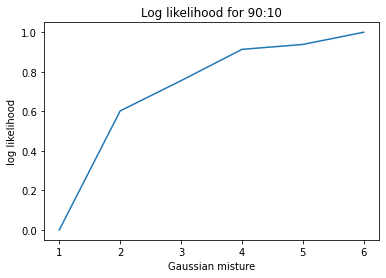

In [ ]:
train_dataset5,test_dataset5 = p4_split_dataset(p4dataset,0.9)
y5 = np.zeros(6)
x5 = np.array([1,2,3,4,5,6])
for number_of_Gaussian in x5:
  Means5,Pi5 = p4_GMM_training(train_dataset5,5,number_of_Gaussian)
  accuracy5,confusion_matrix5 = p4_GMM_testing(test_dataset5,10,Means5,Pi5,number_of_Gaussian)
  TP5=[]
  TN5=[]
  FP5=[]
  FN5=[]
  F15=[]
  for i in range(classes):
    TP5.append(confusion_matrix5[i][i])
    TN5.append(np.sum(confusion_matrix5)-np.sum(confusion_matrix5[i,:])-np.sum(confusion_matrix5[:,i])+confusion_matrix5[i][i])
    FP5.append(np.sum(confusion_matrix5[i,:])-confusion_matrix5[i][i])
    FN5.append(np.sum(confusion_matrix5[:,i])-confusion_matrix5[i][i])
    F15.append((2*TP5[i])/(2*TP5[i] + FP5[i] + FN5[i]))
  y5[number_of_Gaussian-1] = p4_get_likelihood(train_dataset5,Means5,Pi5,number_of_Gaussian)
  print("Accuracy for ",number_of_Gaussian," mixtures is : ",accuracy5)
  print("F1 scores ",number_of_Gaussian," mixtures is : ",F15)
  print("Confusion matrix for ",number_of_Gaussian," mixtures is : ",confusion_matrix5)

y5 = (y5-np.min(y5))/(np.max(y5)-np.min(y5))
plt.plot(x5,y5)
plt.title("Log likelihood for 90:10")
plt.ylabel("log likelihood")
plt.xlabel("Gaussian misture")
plt.show()

## Likelihood curve for EM for various models

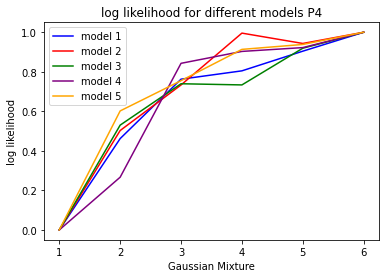

In [ ]:
fig, ax = plt.subplots()
x=x1
# Plot each dataset in its own subplot
ax.plot(x, y1, color='blue',label = 'model 1')
ax.plot(x, y2, color='red',label = 'model 2')
ax.plot(x, y3, color='green',label = 'model 3')
ax.plot(x, y4, color='purple',label = 'model 4')
ax.plot(x, y5, color='orange',label = 'model 5')

ax.set_xlabel('Gaussian Mixture')
ax.set_ylabel('log likelihood')
ax.set_title('log likelihood for different models P4')
ax.legend()
plt.show()

## ROC curve for different models

In [ ]:
# Converting to required dataset format
req_dtst = dataset[:,:-1]/255
y = dataset[:,-1]
y=y.astype(int)
req_dtst = np.column_stack((y,req_dtst,))
req_dtst

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [9., 1., 1., ..., 1., 1., 1.],
       [9., 1., 1., ..., 1., 1., 1.],
       [9., 1., 1., ..., 1., 1., 1.]])

In [ ]:
def ROC_curve(count):
  classes = 2
  # creating training datas for different class
  temp = req_dtst[0:count,:]
  lst = []
  ans = []
  for i in range(classes):
    x1 = temp[np.where(temp[:,0]==i)]
    x = x1[:,1:]
    y = x1[:,0]
    y=y.reshape((y.shape[0],1))
    lst.append(x)
    ans.append(y)
  l = np.row_stack((lst[0],lst[1]))
  m = np.row_stack((ans[0],ans[1]))
  mean=[]   # 10 features' mean for each classes
  for i in range(classes):
    a=lst[i]
    a = a.mean(axis=0)
    mean.append(a)
  TPR=[]
  FPR=[]
  for j in range(10):
    threshold=(j-5)/100
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(l.shape[0]):
      v = (l[i]-mean[0])
      v = np.power(v,2)
      k = 0.5 * np.sum(v)
      k1 = math.exp(-k)
      v = (l[i]-mean[1])
      v = np.power(v,2)
      k = 0.5 * np.sum(v)
      k2 = math.exp(-k)
      if k1-k2>threshold:
        k=1
      else:
        k=0
      if k==int(m[i][0]) and k==1:
        TP+=1
      elif k==int(m[i][0]) and k==0:
        TN+=1
      elif k!=int(m[i][0]) and k==1:
        FP+=1
      else:
        FN+=1
      # print(TP)
      # print(TN)
      # print(FP)
      # print(FN)
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
  plt.plot(TPR,FPR)
  return TPR,FPR

In [ ]:
x1,y1 = ROC_curve(12000) # model 1 20:80

In [ ]:
x2,y2=ROC_curve(18000) # model 1 30:70

In [ ]:
x3,y3=ROC_curve(30000) # model 1 50:50

In [ ]:
x4,y4=ROC_curve(42000) # model 1 70:30

In [ ]:
x5,y5=ROC_curve(54000) # model 1 90:10

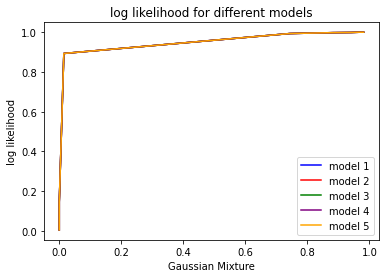

In [ ]:
fig, ax = plt.subplots()
# Plot each dataset in its own subplot
ax.plot(x1, y1, color='blue',label = 'model 1')
ax.plot(x1, y2, color='red',label = 'model 2')
ax.plot(x1, y3, color='green',label = 'model 3')
ax.plot(x1, y4, color='purple',label = 'model 4')
ax.plot(x1, y5, color='orange',label = 'model 5')

ax.set_xlabel('Gaussian Mixture')
ax.set_ylabel('log likelihood')
ax.set_title('log likelihood for different models')
ax.legend()
plt.show()